In [13]:
import numpy as np
import matplotlib.pyplot as plt
import graphlearning as gl
from scipy.optimize import minimize, LinearConstraint
import sklearn.datasets as datasets


$$I[u] = \frac{1}{2p} \sum_{i,j=1}^n w_{i j} | \nabla u(x_i,x_j) |^p - \sum_{j=1}^m(y_j - \bar{y}) \cdot u(x_j)$$
where $$ \nabla u(x_i, x_j) = u(x_j) - u(x_i) $$

In [14]:
# Calculates vector of degrees for the weight matrix W
# W: (n,k) numpy array
    
def degrees(W):
    return W.sum(axis = 1)

# Example
# Calculates degrees of equilateral triangle
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# print(degrees(W))

"""
Computes the gradient of u
u: (n,k) matrix
"""
def grad(u):
    n = u.shape[0]
    k = u.shape[1]
    gradu = np.zeros((n,n,k))
    for i in range(n):
        for j in range(n):
            gradu[i][j] = u[j] - u[i]
    return gradu
            
"""
u_flattened: n*k matrix
W: weight matrix
y: (m,k) matrix
idx = vector of labelled indices
p = p constant for laplace operator
"""
def penergy(u_flattened, W, idx, y, p):
    k = y.shape[1]
    n = int(u_flattened.size/k)
    u = u_flattened.reshape((n,k))
    gradu = grad(u)
    y_bar = (1/y.shape[0]) * y.sum(axis = 0)
    
    first_summand = (1/(2*p)) * (np.apply_along_axis(np.linalg.norm, 2, gradu) ** p).sum()
    second_summand = np.sum( (y - y_bar) * u[idx] )

    return first_summand - second_summand

## Example (see pdf)
u = np.array([[1,0], [0,1], [1/2, 1/2]])
print(grad(u))
y = np.array([[1,0], [0,1]])
W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
idx = [0, 1]
p = 2

#print(np.apply_along_axis(np.linalg.norm, 2, grad(u)))
print("2-energy is", penergy(u, W, idx, y, 2))
print("3-energy is", penergy(u, W, idx, y, 3))

# Returns the ith vector of the usual basis of R^k
# Index starts at 0
def euclidean_basis(i, k):
    eye = np.eye(k)
    return eye[i]

# Example
# print(euclidean_basis(0, 4))
# print(euclidean_basis(2, 4))

# Returns the labels that u predicts
def predict(u):
    return np.argmax(u, axis = 1)

def slow_penergy(u_flattened, W, idx, y, p):
    k = y.shape[1]
    n = int(u_flattened.size/k)
    m = y.shape[0]
    u = u_flattened.reshape((n,k))
    gradu = grad(u)
    
    y_bar = (1/y.shape[0]) * y.sum(axis = 0)
    
    first_summand = 0
    for i in range(n):
        for j in range(n):
            first_summand += np.linalg.norm(gradu[i,j])**p
    first_summand /= 2 * p
    
    second_summand = 0
    for j in range(m):
        second_summand += np.inner( (y[j]-y_bar), u[j])
    
    return first_summand - second_summand



[[[ 0.   0. ]
  [-1.   1. ]
  [-0.5  0.5]]

 [[ 1.  -1. ]
  [ 0.   0. ]
  [ 0.5 -0.5]]

 [[ 0.5 -0.5]
  [-0.5  0.5]
  [ 0.   0. ]]]
2-energy is 0.5000000000000004
3-energy is 0.17851130197757947


In [15]:
def started_gradient_ppoisson(W, idx, y, p, start):
    d = degrees(W)
    n = W.shape[0]
    k = y.shape[1]
    eye = np.eye(k)

    constrain_matrix = np.concatenate([d[i] * eye for i in range(n)], axis = 1)
    # print(constrain_matrix)
    linear_constraint = LinearConstraint(constrain_matrix, np.zeros(k), np.zeros(k))
    res = minimize(slow_penergy, x0 = start, args = (W, idx, y, p), method = 'trust-constr', constraints = linear_constraint)
    u = res.x.reshape(n,k)
    
    return u

def gradient_ppoisson(W, idx, y, p):
    d = degrees(W)
    n = W.shape[0]
    k = y.shape[1]
    eye = np.eye(k)

    constrain_matrix = np.concatenate([d[i] * eye for i in range(n)], axis = 1)
    # print(constrain_matrix)
    linear_constraint = LinearConstraint(constrain_matrix, np.zeros(k), np.zeros(k))
    res = minimize(slow_penergy, x0 = np.zeros(n * k), args = (W, idx, y, p), method = 'trust-constr', constraints = linear_constraint)
    u = res.x.reshape(n,k)
    
    return u

# Example
y = np.array([[1,0], [0,1]])
W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
idx = [0, 1]
p = 2

u = gradient_ppoisson(W, idx, y, p)
print("Minimizer:\n", u)
print("Energy of minimizer:", penergy(u, W, idx, y, p))
print("Negative Laplacian values:", 2*u[0]-u[1]-u[2], 2*u[1]-u[0]-u[2], 2*u[2]-u[0]-u[1], sep="\n")
print("Labels:", predict(u))

Minimizer:
 [[ 1.66666667e-01 -1.66666666e-01]
 [-1.66666666e-01  1.66666667e-01]
 [-9.77529722e-10 -1.11717683e-09]]
Energy of minimizer: -0.16666666666666666
Negative Laplacian values:
[ 0.5 -0.5]
[-0.5  0.5]
[-2.93258917e-09 -3.35153047e-09]
Labels: [0 1 0]


In [16]:
# Toy example using graph learn
y = np.array([[1,0], [0,1]])
W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
d = degrees(W)
idx = [0, 1]
n = 3
k = 2
p = 2

model = gl.ssl.poisson(W)
u = model.fit(idx, np.array([0, 1]))
# print(2*u[0]-u[1]-u[2])
# print(2*u[1]-u[0]-u[2])
# print(2*u[2]-u[0]-u[1])
# print(u[0] + u[1] + u[2])
print(u)

[[ 0.16666667 -0.16666667]
 [-0.16666667  0.16666667]
 [ 0.          0.        ]]


10
Accuracy: 99.18%


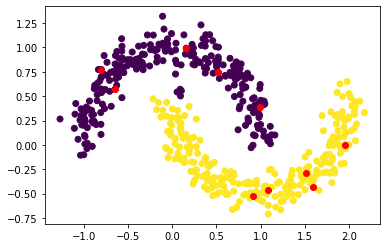

In [17]:
X,labels = datasets.make_moons(n_samples=500,noise=0.1)
W = gl.weightmatrix.knn(X,10,symmetrize=False)


train_ind = gl.trainsets.generate(labels, rate=5)
print(train_ind.size)
train_labels = labels[train_ind]

model = gl.ssl.poisson(W, solver='gradient_descent')
pred_labels = model.fit_predict(train_ind, train_labels)

accuracy = gl.ssl.ssl_accuracy(pred_labels, labels, len(train_ind))   
print("Accuracy: %.2f%%"%accuracy)

plt.scatter(X[:,0],X[:,1], c=pred_labels)
plt.scatter(X[train_ind,0],X[train_ind,1], c='r')
plt.show()

Energy of GraphLearning Solution: 208.2550985339248
Energy of custom solution: 0.09999995741794725


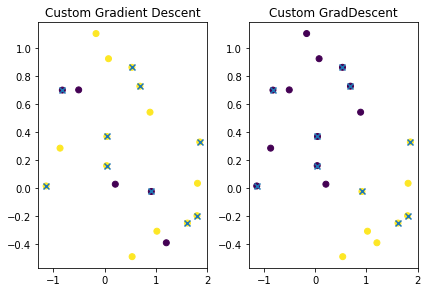

In [18]:
n = 20
k = 2

# Generate training data and label sets
X,labels = datasets.make_moons(n_samples=n,noise=0.1)
W = gl.weightmatrix.knn(X,10).toarray()

train_ind = gl.trainsets.generate(labels, rate=5)
train_labels = labels[train_ind]
m = train_ind.size

y = np.zeros((m, k))
for i in range(train_ind.size):
    y[i] = euclidean_basis(train_labels[i], k)
    
# Custom Gradient Descent
u = gradient_ppoisson(W, train_ind, y, p = 2)
my_pred_labels = predict(u)

fig, ax = plt.subplots(ncols = 2)
fig.tight_layout()

ax[0].scatter(X[:,0],X[:,1], c=my_pred_labels)
ax[0].scatter(X[train_ind,0],X[train_ind,1], marker='x')
ax[0].set_title("Custom Gradient Descent")

# Using graph learning toolkit
train_labels = labels[train_ind]

model = gl.ssl.poisson(W, solver='gradient_descent')
u = model.fit(train_ind, train_labels)
pred_labels = predict(u)
ax[1].scatter(X[:,0],X[:,1], c=pred_labels)
ax[1].scatter(X[train_ind,0],X[train_ind,1], marker='x')
ax[1].set_title("Custom GradDescent")

print("Energy of GraphLearning Solution:", penergy(u.flatten(), W, train_ind, y, p))
print("Energy of custom solution:", penergy(my_u.flatten(), W, train_ind, y, p))

plt.show()

Energy of GraphLearning Solution: 138.1224579647321
Energy of custom solution: 0.19999990040883198


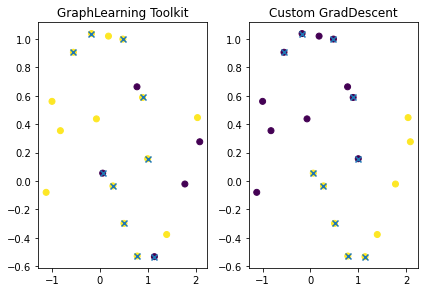

In [19]:
n = 20
k = 2

X,labels = datasets.make_moons(n_samples=n,noise=0.1)
W = gl.weightmatrix.knn(X,10).toarray()

train_ind = gl.trainsets.generate(labels, rate=5)
train_labels = labels[train_ind]

fig, ax = plt.subplots(ncols = 2)
fig.tight_layout()

train_labels = labels[train_ind]

model = gl.ssl.poisson(W, solver='gradient_descent')
u = model.fit(train_ind, train_labels)
pred_labels = predict(u)
ax[1].scatter(X[:,0],X[:,1], c=pred_labels)
ax[1].scatter(X[train_ind,0],X[train_ind,1], marker='x')
ax[1].set_title("Custom GradDescent")


m = train_ind.size

y = np.zeros((m, k))
for i in range(train_ind.size):
    y[i] = euclidean_basis(train_labels[i], k)
    
my_u = started_gradient_ppoisson(W, train_ind, y, 2, u.flatten())
pred_labels = predict(my_u)

ax[0].scatter(X[:,0],X[:,1], c=pred_labels)
ax[0].scatter(X[train_ind,0],X[train_ind,1], marker='x')
ax[0].set_title("GraphLearning Toolkit")

print("Energy of GraphLearning Solution:", penergy(u.flatten(), W, train_ind, y, p))
print("Energy of custom solution:", penergy(my_u.flatten(), W, train_ind, y, p))

plt.show()